# MACE in Practice I

In this tutorial, you will learn how to fit and test a `MACE` model (Message Passing Neural Network), which is a highly accurate and efficient MLIP (Machine Learnt Interatomic Potential). The training/testing techniques we show here, however, are broadly applicable to all MLIPs. You can independently learn about MACE by studying the [original method paper](https://proceedings.neurips.cc/paper_files/paper/2022/file/4a36c3c51af11ed9f34615b81edb5bbc-Paper-Conference.pdf). MACE was developed by unifying the Atomic Cluster Expansion (ACE) approach with the Neural Equivariant Interatomic Potentials (NequIP). The mathematical formalism which unifies these methods is explained in the [accompaning paper](https://doi.org/10.48550/arXiv.2205.06643). Another [useful reference](https://doi.org/10.48550/arXiv.2305.14247) showcases the method's performance on published benchmark datasets. The [code implementation](https://github.com/ACEsuit/mace) is publically available and [here](https://mace-docs.readthedocs.io/en/latest/) you can find the documentation.

## Learning Objectives for today:

1. **Understanding the data: diverse configs, reference labels**
2. **Understanding MACE parameters: architecture and training**
3. **Fitting and testing MACE models**
4. **Ultimate goal: stable and accurate Molecular Dynamics**
5. **Iterative Training: improving stability and accuracy**

## 1. Understanding the data

### 1.1 Diverse Molecular Conformations

Understanding the data is a crucial part of fitting an MLIP. Most models will underperform at first, often because of insufficiently representative data.
In this application, we will develop an MLIP for molecular liquids of carbonates. The data comprises a mixture of 6 different types of molecules: cyclic carbonates (Vinylene carbonate VC, Ethylene carbonate EC, Propylene carbonate PC) and linear carbonates (Dimethyl carbonate DMC, Ethyl Methyl Carbonate EMC, Diethyl carbonate DEC). Mixtures of these molecules in various formulations are used as solvents in Li-ion battery electrolytes.

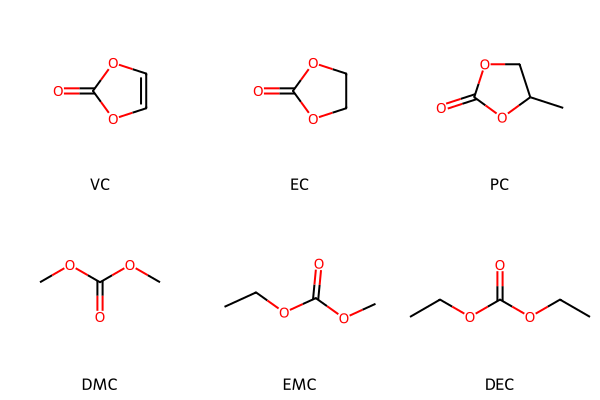

In [1]:
from rdkit import Chem
from rdkit.Chem import Draw

# SMILES strings for each molecule
sm_dict = {
    'VC': 'c1coc(=O)o1',
    'EC': 'C1COC(=O)O1',
    'PC': 'CC1COC(=O)O1',
    'DMC': 'COC(=O)OC',
    'EMC': 'CCOC(=O)OC',
    'DEC': 'CCOC(=O)OCC'
}

Draw.MolsToGridImage([Chem.MolFromSmiles(sm_dict[mol]) for mol in sm_dict], legends=list(sm_dict.keys()))

For this tutorial, we prepared in advance a collection of atomic configurations (small subset from [this paper](https://doi.org/10.1021/acs.jpcb.2c03746)). Let's understand the data! We start by loading the raw configurations with no `labels` (energy, forces). The atomic `configurations`are stored in the [extxyz](https://wiki.fysik.dtu.dk/ase/ase/io/formatoptions.html#extxyz) format and can be accessed using [ASE](https://wiki.fysik.dtu.dk/ase/index.html) as shown below:

In [2]:
from ase.io import read, write
import numpy as np

db = read('data/solvent_configs.xyz', ':') #read in list of configs

print("Number of configs in database: ", len(db))
print("Number of atoms in each config: ", np.array([len(at) for at in db]))
print("Number of atoms in the smallest config: ", np.min([len(at) for at in db])) #test if database contains isolated atoms
print("Information stored in config.info: \n", db[10].info) #check info
print("Information stored in config.arrays: \n", db[10].arrays)

Number of configs in database:  5000
Number of atoms in each config:  [24 22 25 ... 25 32 40]
Number of atoms in the smallest config:  8
Information stored in config.info: 
 {}
Information stored in config.arrays: 
 {'numbers': array([6, 8, 6, 8, 6, 1, 1, 8, 1, 1, 6, 8, 8, 8, 6, 6, 6, 1, 1, 6, 1, 1,
       1, 1, 1, 1, 1, 1]), 'positions': array([[ 2.42930269,  5.21925545, -2.44555688],
       [ 1.36888075,  4.36736107, -3.07848001],
       [ 1.0430907 ,  3.33270121, -2.205446  ],
       [ 1.83499873,  3.2705152 , -1.20140588],
       [ 2.83662271,  4.2916441 , -1.29654086],
       [ 3.20092463,  5.52685308, -3.12019396],
       [ 1.98896468,  6.07220507, -2.07261896],
       [ 0.15712669,  2.55914021, -2.58440089],
       [ 3.80655074,  3.73805737, -1.62337792],
       [ 3.03487277,  4.82053137, -0.40139091],
       [-1.35643137, -2.96665978,  1.35700715],
       [-1.21188033, -2.7462728 ,  0.1501831 ],
       [-0.54117233, -3.68505168,  2.08627701],
       [-2.42475724, -2.65949082,  

You can visualize `*.xyz` files using `ovito`. You can launch the `Desktop` application from the `Launcher` and navigate to your working directory.

At this point each configuration is a collection of atoms: atomic number (Z) and positions (R), with no additional information. Let's identify the molecules and label molecular clusters. This will make it easier to inspect the data set and, later, test the accuracy of the potential on describing inter-molecular interactions. Molecule identification is achieved using the `wrap_molecs` function from the [aseMolec package](https://github.com/imagdau/aseMolec), shown here for the first 100 frames `db[:100]`.

In [3]:
from aseMolec import anaAtoms as aa

aa.wrap_molecs(db[:100], prog=False) #identify molecules and label molecular clusters, showcase: first 100 frames
# write('data/solvent_molecs.xyz', db) #save full result
print("Information stored in config.info: \n", db[10].info)
print("Information stored in config.arrays: \n", db[10].arrays)

Information stored in config.info: 
 {'Nmols': 2, 'Comp': 'DEC(1):EC(1)'}
Information stored in config.arrays: 
 {'numbers': array([6, 8, 6, 8, 6, 1, 1, 8, 1, 1, 6, 8, 8, 8, 6, 6, 6, 1, 1, 6, 1, 1,
       1, 1, 1, 1, 1, 1]), 'positions': array([[ 2.42930269,  5.21925545, -2.44555688],
       [ 1.36888075,  4.36736107, -3.07848001],
       [ 1.0430907 ,  3.33270121, -2.205446  ],
       [ 1.83499873,  3.2705152 , -1.20140588],
       [ 2.83662271,  4.2916441 , -1.29654086],
       [ 3.20092463,  5.52685308, -3.12019396],
       [ 1.98896468,  6.07220507, -2.07261896],
       [ 0.15712669,  2.55914021, -2.58440089],
       [ 3.80655074,  3.73805737, -1.62337792],
       [ 3.03487277,  4.82053137, -0.40139091],
       [-1.35643137, -2.96665978,  1.35700715],
       [-1.21188033, -2.7462728 ,  0.1501831 ],
       [-0.54117233, -3.68505168,  2.08627701],
       [-2.42475724, -2.65949082,  2.02500916],
       [ 0.77742571, -4.09808683,  1.66831815],
       [-3.53945827, -1.88707876,  1.42200

Note the additional information for each atomic config: number of molecules `Nmols`, molecular composition `Comp` (e.g `DEC(1):EC(1)` means the config comprises a dimer with 1 DEC molecule and 1 EC molecule) and molecular ID `molID`. Running the code for the full 5000 configurations can be slow, let's just load the final result (`data/solvent_molecs.xyz`) and inspect the distribution of configs by number of molecules:

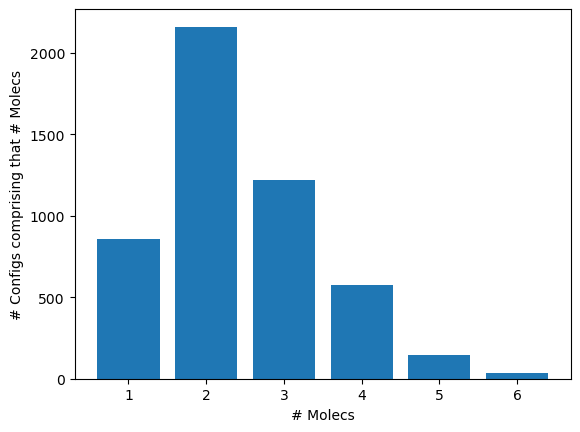

In [4]:
from matplotlib import pyplot as plt

db = read('data/solvent_molecs.xyz', ':')
Nmols = np.array([at.info['Nmols'] for at in db]) #collect Nmols information across all data
plt.hist(Nmols, align='left', bins=[1,2,3,4,5,6,7], rwidth=0.8);
plt.xlabel('# Molecs');
plt.ylabel('# Configs comprising that # Molecs');

There are just under 1000 configs comprising of single molecules and more than 2000 dimers. The largest configs contain clusters of six molecules.

We can check the distribution of molecular compositions for each cluster size:

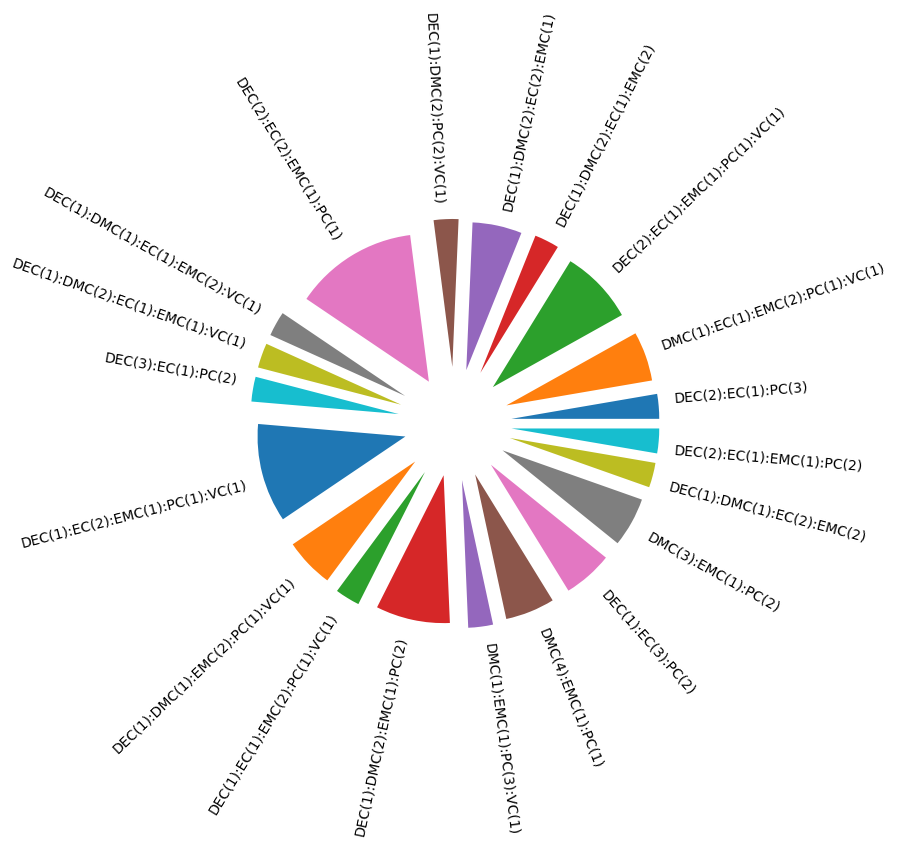

In [5]:
from aseMolec import extAtoms as ea
from collections import Counter

comp_dict = {} #create a dictionary of compositions for each cluster size
for Nmol in range(1,7):
    comp_dict[Nmol] = dict(Counter([at.info['Comp'] for at in ea.sel_by_info_val(db, 'Nmols', Nmol)]))

Nmol = 6 #show distribution of compositions for cluster size 6
plt.pie(comp_dict[Nmol].values(),
        labels=comp_dict[Nmol].keys(),
        explode=10/(25+np.array(list(comp_dict[Nmol].values()))),
        rotatelabels =True);

The training set is quite diverse and it contains a good mix of compositions. Check the distribution for other cluster sizes: `Nmol = 1, 2, 3, 4, 5`. Find out if all isolated molecules are present and well sampled. We have six molecules, so there should be 6x7/2 dimers present, are all dimers sampled?

### 1.2 Labeling Data with XTB Values

We convinced ourselves the training set is quite diverse, it samples many compositions and molecular cluster sizes. It is time to prepare the reference data (energies, forces) to train the model on. We will do this using the Semiempirical Tight Binding level of theory with [XTB](https://xtb-docs.readthedocs.io/en/latest/contents.html). This may be less accurate than other methods specialized for these systems, but it is fast and it will later allow us to test MLIP errors on-the-fly.

Notice the data set contains isolated molecules but no isolated atoms. MACE (and other MLIPs) fit to atomization energies (eV) which is total energy minus the energy of each atom in vacuum $(E^{0})$:
$$
E^{\rm atm} = E^{\rm tot}-\sum_i^{N} E^{0}
$$

In our specific example, all molecules comprise of three chemical elements and we will need to compute $(E^{0})$ for each of them:

$$
E^{\rm atm} = E^{\rm tot}-\sum_i^{N_H} E^{H}_i-\sum_i^{N_C} E^{C}_i-\sum_i^{N_O} E^{O}_i
$$

Let us add three frames containing Hydrogen H, Carbon C and Oxygen O to the dataset and label them as `config_type=IsolatedAtom`

In [6]:
from ase import Atoms

db = read('data/solvent_molecs.xyz', ':')
db = [Atoms('H'), Atoms('C'), Atoms('O')]+db #add isolated atoms to the database

for at in db[:3]:
    at.info['config_type'] = 'IsolatedAtom'

print("Number of configs in database: ", len(db))

Number of configs in database:  5003


We are now ready to compute the energy and forces with XTB:

In [7]:
from tqdm import tqdm
from xtb.ase.calculator import XTB
xtb_calc = XTB(method="GFN2-xTB")

for at in tqdm(db[:15]): #showcase: first 15 frames
    at.calc = xtb_calc
    at.info['energy_xtb'] = at.get_potential_energy()
    at.arrays['forces_xtb'] = at.get_forces()
# write('data/solvent_xtb.xyz', db) #save full result

print("Information stored in config.info: \n", db[13].info) #check info
print("Information stored in config.arrays: \n", db[13].arrays)

100%|██████████| 15/15 [00:10<00:00,  1.40it/s]

Information stored in config.info: 
 {'Nmols': 2, 'Comp': 'DEC(1):EC(1)', 'energy_xtb': -1323.8105075136}
Information stored in config.arrays: 
 {'numbers': array([6, 8, 6, 8, 6, 1, 1, 8, 1, 1, 6, 8, 8, 8, 6, 6, 6, 1, 1, 6, 1, 1,
       1, 1, 1, 1, 1, 1]), 'positions': array([[ 2.42930269,  5.21925545, -2.44555688],
       [ 1.36888075,  4.36736107, -3.07848001],
       [ 1.0430907 ,  3.33270121, -2.205446  ],
       [ 1.83499873,  3.2705152 , -1.20140588],
       [ 2.83662271,  4.2916441 , -1.29654086],
       [ 3.20092463,  5.52685308, -3.12019396],
       [ 1.98896468,  6.07220507, -2.07261896],
       [ 0.15712669,  2.55914021, -2.58440089],
       [ 3.80655074,  3.73805737, -1.62337792],
       [ 3.03487277,  4.82053137, -0.40139091],
       [-1.35643137, -2.96665978,  1.35700715],
       [-1.21188033, -2.7462728 ,  0.1501831 ],
       [-0.54117233, -3.68505168,  2.08627701],
       [-2.42475724, -2.65949082,  2.02500916],
       [ 0.77742571, -4.09808683,  1.66831815],
       [-3

The updated data contains one energy value for each config `energy_xtb` and the `forces_xtb` on each atom. Latest version of [ASE](https://wiki.fysik.dtu.dk/ase/index.html) does not support simple names such as `energy` and `forces` so we append `_xtb`. The entire computation takes about `25 mins` for the 5003 configs. We have precomputed the data, so we can simply load the final result. Let's check the $E^0$ values and atomization energies:

In [8]:
db = read('data/solvent_xtb.xyz', ':15')

print("E0s: \n", ea.get_E0(db, tag='_xtb'))
print("Total energy per config: \n", ea.get_prop(db, 'info', 'energy_xtb', peratom=False)[13])
print("Toal energy per atom: \n", ea.get_prop(db, 'info', 'energy_xtb', peratom=True)[13])
print("Atomization energy per config: \n", ea.get_prop(db, 'bind', prop='_xtb', peratom=False)[13])
print("Atomization energy per atom: \n", ea.get_prop(db, 'bind', prop='_xtb', peratom=True)[13])

E0s: 
 {'H': -10.707211383396714, 'C': -48.847445262804705, 'O': -102.57117256025786}
Total energy per config: 
 -1323.8105075135763
Toal energy per atom: 
 -47.278946696913444
Atomization energy per config: 
 -167.70295068203745
Atomization energy per atom: 
 -5.9893910957870515


Good! We get about -6 $\rm eV/atom$ which is largely dominated by the energy of the [covalent bonds](https://en.wikipedia.org/wiki/Bond-dissociation_energy#:~:text=of%20a%20solvent.-,Representative%20bond%20enthalpies,-%5Bedit%5D). Remember, the largest contribution to the total energy comes from $E^0$ and then from covalent bonds. The noncovalent interactions contribute a very small amount to the total energy, yet they are crucial for molecular dynamics.

## 2. Understanding MACE parameters

### 2.1 Model parameters

We'll give a high-level explanation of the important parameters in MACE. We will discuss these in detail during the third tutorial and associated lectures. Consult the [documentation](https://github.com/ACEsuit/mace) for additional parameters.

- ##### <font color='red'>--num_interactions</font>: message-passing layers

Controls the number of message-passing layers in the model.

- ##### <font color='red'>--hidden_irreps</font>: number of message passing layers

Determines the size of the model and its symmetry.
For example: `hidden_irreps='128x0e'` means the model has `128` channels or paths, the output is invariant under rotation ($L_{\rm max}=0$) and even under inversion (`'e'`). For most applications, these settings will do well. `hidden_irreps='64x0e + 64x1o'` means the model has `64` channels and is equivariant under rotation ($L_{\rm max}=0$).

Alternatively, the model size can be adjusted using a pair of more user-friendly arguments:

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; <font color='red'>--num_channels=32</font>

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; <font color='red'>--max_L=2</font>

which, taken together achieve the same as <font color='red'>--hidden_irreps='32x0e + 32x1o + 32x2e'</font>
    
<font color='blue'>**In general, the `accuracy` of the model can be improved by using more layers, more channels or higher equivariances. This will result in more parameters and `slower` models.**</font>

- ##### <font color='red'>--correlation</font>: the order of the many-body expansion
$$
E_{i} = E^{(0)}_{i} + \sum_{j} E_{ij}^{(1)} + \sum_{jk} E_{ijk}^{(2)} + ...
$$

The energy-expansion order that MACE induces at each layer. Choosing `--correlation=3` will create basis functions of up to 4-body (ijkl) indices, for each layer. If the model has multiple layers, the effective correlation order is higher. For example, a two-layer MACE with `--correlation=3` has an effective body order of `13`.

- ##### <font color='red'>--r_max</font>: the cutoff radius

The cut-off applied to local environment in each layer. `r_max=3.0` means atoms separated by a distance of more than 3.0 A do not directly `communicate`. When the model has multiple message-passing layers, atoms further than 3.0 A can still `communicate` through later messages if intermediate proxy atoms exist. The effective `receptive field` of the model is `num_interactions x r_max`.

- ##### <font color='red'>--max_ell</font>: angular resolution

The angular resolution describes how well the model can describe angles. This is controlled by `l_max` of the spherical harmonics basis (not to be confused with `L_max`). Larger values will result in more accurate but slower models. The default is `l_max=3`, appropriate in most cases.

Let's train our first model:

In [89]:
!mace_run_train \
    --model="MACE" \
    --num_interactions=2 \
    --num_channels=32 \
    --max_L=0 \
    --correlation=2 \
    --r_max=4.0 \
    --max_ell=2

usage: mace_run_train [-h] [--config CONFIG] --name NAME [--seed SEED]
                      [--log_dir LOG_DIR] [--model_dir MODEL_DIR]
                      [--checkpoints_dir CHECKPOINTS_DIR]
                      [--results_dir RESULTS_DIR]
                      [--downloads_dir DOWNLOADS_DIR]
                      [--device {cpu,cuda,mps}]
                      [--default_dtype {float32,float64}] [--distributed]
                      [--log_level LOG_LEVEL]
                      [--error_table {PerAtomRMSE,TotalRMSE,PerAtomRMSEstressvirials,PerAtomMAE,TotalMAE,DipoleRMSE,DipoleMAE,EnergyDipoleRMSE}]
                      [--model {BOTNet,MACE,ScaleShiftMACE,ScaleShiftBOTNet,AtomicDipolesMACE,EnergyDipolesMACE}]
                      [--r_max R_MAX]
                      [--radial_type {bessel,gaussian,chebyshev}]
                      [--num_radial_basis NUM_RADIAL_BASIS]
                      [--num_cutoff_basis NUM_CUTOFF_BASIS] [--pair_repulsion]
                      [--distan

This won't work, of course, we still need to supply the training data and a model name, at a minimum. In fact, let's take a look at the remaining parameters which control the file management and training protocol.

### 2.2 Training and data management parameters

Let's start by splitting the data into a train and test set.

In [90]:
from ase.io import read, write

db = read('data/solvent_xtb.xyz', ':')
write('data/solvent_xtb_train_200.xyz', db[:203]) #first 200 configs plus the 3 E0s
write('data/solvent_xtb_test.xyz', db[-1000:]) #last 1000 configs

- ##### <font color='red'>--name</font>: the name of the model
This name will be used to form file names (model, log, checkpoints, results), so choose a distinct name for each experiment

- ##### <font color='red'>--model_dir, --log_dir, --checkpoints_dir, --results_dir</font>: directory paths
These are the directories where each type of file is saved. For simplicity, we will all files in the same directory.

- ##### <font color='red'>--train_file</font>: name of training data

These data configs are used to compute gradients and update model parameters.

- ##### <font color='red'>--valid_file</font>: name of validation data
An alternative way to choose the validation set is by using the `--valid_fraction` keyword. These data configs are used to estimate the model accuracy during training, but not for parameter optimization. The validation set also controls the stopping of the training. At each `--eval_interval` the model is tested on the validation set. The evaluation of these configs takes place in batches, which can be controlled by `--valid_batch_size`. If the accuracy of the model stops improving on the validation set for `--patience` number of epochs, the model will undergo **early stopping**. 

- ##### <font color='red'>--test_file</font>: name of testing data

This set is entirely independent and only gets evaluated at the end of the training process to estimate the model accuracy on an independent set.

- ##### <font color='red'>--E0s</font>: isolated atom energies

Controls how `E0s` should be determined. The strongly recommended approach is to add these values to the training set with `config_type=IsolatedAtom` in `atoms.info` and set `E0s="isolated"`. If these values are not available, MACE can estimate them by least square regression over the available data `E0s="average"` which can lead to unintended consequences depending on how representative the data is.

- ##### <font color='red'>--energy_key, --forces_key</font> the key where these values are stores
This key must coincide with the `ase.Atoms.info[key]/ase.Atoms.arrays[key]` where the energies and forces are stored in the ase.Atoms object.

- ##### <font color='red'>--device</font> computing device to use
Can be CPU (`cpu`), GPU (`cuda`) or Apple Silicon (`mps`). Here we will use `cuda` since the GPU will be significantly faster than the CPU.

- ##### <font color='red'>--batch_size</font> number of configs evaluated in one batch
Number of configs used to compute the gradients for each full update of the network parameters. This training strategy is called stochastic gradient descent because only a subset of the data (`batch_size`) is used to change the parameters at each update.

- ##### <font color='red'>--max_num_epochs</font> number of passes through the data
An `epoch` is completed when the entire training data has been used once in updating the weights `batch` by `batch`. A new epoch begins, and the process repeats.

- ##### <font color='red'>--swa</font> protocol for loss weights
During training you will notice energy errors are at first much higher than force errors, MACE implements a special protocol that increases the weight on the energy in the loss function (`--swa_energy_weight`) once the forces are sufficiently accurate. The starting epoch for this special protocol can be controlled by changing `--start_swa`.

- ##### <font color='red'>--seed</font> random number generator seed
Useful for preparing committee of models.

Now we are ready to fit our first MACE model:

## 3. Fitting and Testing MACE models

### 3.1 Fitting the model

In [140]:
!mace_run_train \
    --model="MACE" \
    --num_interactions=2 \
    --num_channels=32 \
    --max_L=0 \
    --correlation=2 \
    --r_max=4.0 \
    --max_ell=2 \
    --name="mace01" \
    --model_dir="MACE_models" \
    --log_dir="MACE_models" \
    --checkpoints_dir="MACE_models" \
    --results_dir="MACE_models" \
    --train_file="data/solvent_xtb_train_200.xyz" \
    --valid_fraction=0.10 \
    --test_file="data/solvent_xtb_test.xyz" \
    --E0s="average" \
    --energy_key="energy_xtb" \
    --forces_key="forces_xtb" \
    --device=cuda \
    --batch_size=10 \
    --max_num_epochs=50 \
    --swa \
    --seed=123

#remove checkpoints since they may cause errors on retraining a model with the same name but a different architecture
import glob
import os
for file in glob.glob("MACE_models/*.pt"):
    os.remove(file)

2024-07-21 14:16:39.186 INFO: MACE version: 0.3.6
2024-07-21 14:16:39.187 INFO: Configuration: Namespace(config=None, name='mace01', seed=123, log_dir='MACE_models', model_dir='MACE_models', checkpoints_dir='MACE_models', results_dir='MACE_models', downloads_dir='downloads', device='cuda', default_dtype='float64', distributed=False, log_level='INFO', error_table='PerAtomRMSE', model='MACE', r_max=4.0, radial_type='bessel', num_radial_basis=8, num_cutoff_basis=5, pair_repulsion=False, distance_transform='None', interaction='RealAgnosticResidualInteractionBlock', interaction_first='RealAgnosticResidualInteractionBlock', max_ell=2, correlation=2, num_interactions=2, MLP_irreps='16x0e', radial_MLP='[64, 64, 64]', hidden_irreps='128x0e + 128x1o', num_channels=32, max_L=0, gate='silu', scaling='rms_forces_scaling', avg_num_neighbors=1, compute_avg_num_neighbors=True, compute_stress=False, compute_forces=True, train_file='data/solvent_xtb_train_200.xyz', valid_file=None, valid_fraction=0.1, t

Monitor the memory and usage of your GPU using `nvitop` in the `terminal`. What changes when increasing the `batch_size`? How about when changing the model size (`num_interactions`, `num_channels`, `max_L`, `correlation`)? Notice the accuracy vs speed trade-off.

##### <font color='purple'> **Question: Here we trained on a very small subset of the data, repeat training for 400, 1000, 2000, 4000 data points, remember to change the name of the model accordingly. How does the learning curve (test error vs size of training test) look like?** </font>

We will now use the `mace_eval_configs` script to evaluate the trained model on both the train and test datasets. The script takes the arguments: `--configs` which specifies the file to evaluate, the path to the model in `--model` and the path to the output in `--output`.

### 3.2 Testing the model: simple RMSEs

In [141]:
import warnings
warnings.filterwarnings("ignore")

os.makedirs("tests/mace01/", exist_ok=True)

#evaluate the train set
!mace_eval_configs \
    --configs="data/solvent_xtb_train_200.xyz" \
    --model="MACE_models/mace01_swa_compiled.model" \
    --output="tests/mace01/solvent_train.xyz"

#evaluate the test set
!mace_eval_configs \
    --configs="data/solvent_xtb_test.xyz" \
    --model="MACE_models/mace01_swa_compiled.model" \
    --output="tests/mace01/solvent_test.xyz"

/opt/conda/lib/python3.10/site-packages/torch/serialization.py:1007: UserWarning: 'torch.load' received a zip file that looks like a TorchScript archive dispatching to 'torch.jit.load' (call 'torch.jit.load' directly to silence this warning)
  warnings.warn("'torch.load' received a zip file that looks like a TorchScript archive"
/opt/conda/lib/python3.10/site-packages/torch/serialization.py:1007: UserWarning: 'torch.load' received a zip file that looks like a TorchScript archive dispatching to 'torch.jit.load' (call 'torch.jit.load' directly to silence this warning)
  warnings.warn("'torch.load' received a zip file that looks like a TorchScript archive"


We can compare MACE vs XTB accuracy on the train and test sets and for this we will use the [aseMolec](git@github.com:imagdau/aseMolec.git) which implements some handy utilities for manipulating ase.Atoms and testing potentials, especially for molecular systems.

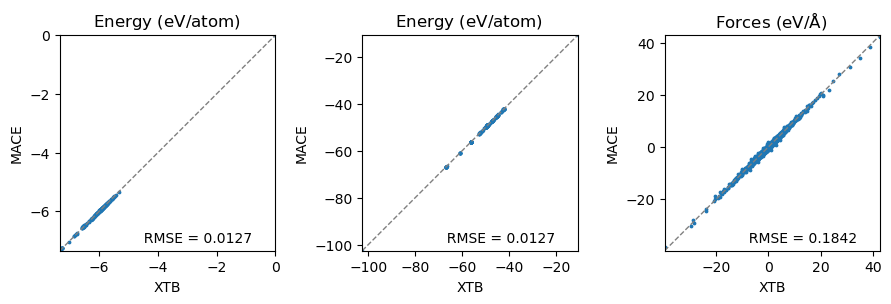

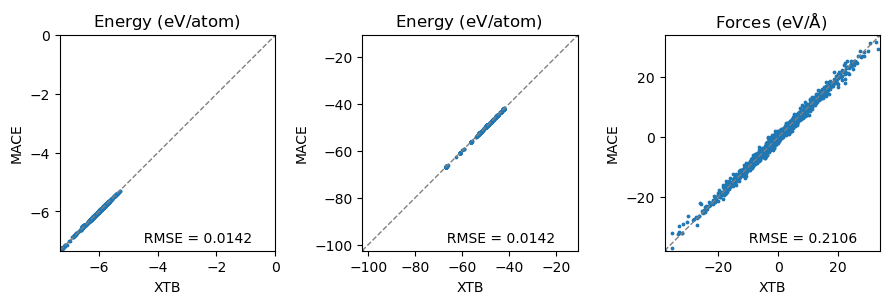

In [137]:
from aseMolec import pltProps as pp
from ase.io import read
import matplotlib.pyplot as plt
from aseMolec import extAtoms as ea
import numpy as np

def plot_RMSEs(db, labs):
    ea.rename_prop_tag(db, 'MACE_energy', 'energy_mace') #Backward compatibility
    ea.rename_prop_tag(db, 'MACE_forces', 'forces_mace') #Backward compatibility
    
    plt.figure(figsize=(9,6), dpi=100)
    plt.subplot(1,3,1)
    pp.plot_prop(ea.get_prop(db, 'bind', '_xtb', True).flatten(), \
                 ea.get_prop(db, 'bind', '_mace', True).flatten(), \
                 title=r'Energy $(\rm eV/atom)$ ', labs=labs, rel=False)
    plt.subplot(1,3,2)
    pp.plot_prop(ea.get_prop(db, 'info', 'energy_xtb', True).flatten(), \
                 ea.get_prop(db, 'info', 'energy_mace', True).flatten(), \
                 title=r'Energy $(\rm eV/atom)$ ', labs=labs, rel=False)
    plt.subplot(1,3,3)
    pp.plot_prop(np.concatenate(ea.get_prop(db, 'arrays', 'forces_xtb')).flatten(), \
                 np.concatenate(ea.get_prop(db, 'arrays', 'forces_mace')).flatten(), \
                 title=r'Forces $\rm (eV/\AA)$ ', labs=labs, rel=False)
    plt.tight_layout()
    return

train_data = read('tests/mace01/solvent_train.xyz', ':')
test_data = train_data[:3]+read('tests/mace01/solvent_test.xyz', ':') #append the E0s for computing atomization energy errors

plot_RMSEs(train_data, labs=['XTB', 'MACE'])
plot_RMSEs(test_data, labs=['XTB', 'MACE'])

These figures show correlation plots between XTB values and MACE predicted values for atomization energy per atom, total energy per atom and forces. Do the RMSE values match the number printed at the end of the model training? These errors don't look too bad, and this MACE is a small model with few parameters. Significantly better accuracies can be achieved when training on larger models with more data. How does your model trained on 4000 configs compare?

### 3.2 Testing on the Intra/Inter decomposition:

As shown in this [paper](https://doi.org/10.1038/s41524-023-01100-w) one of the challenges associated with modelling molecular systems has to do with the  inter-molecular interactions.
Molecular dynamics is primarily driven by these inter-molecular interactions, however they are relatively small in comparison to covalent interactions and prove difficult to capture with MLIPs.
The paper introduces this protocol to decompose the force errors into [intra- and inter-] molecular RMSEs to gauge the quality of the potential separately on the two interaction scales. This approach can be summarized as follows:
1. Identify molecules (labeled **j**).  

2. Within each molecule **j** sum over all atomic forces (labeled **k**) to obtain the **translational** component:
$$F^{\rm trans}_j = \sum_{k \in j} f_{k}$$

3. Redistribute the molecular **translational** force onto individual atoms (labeled **i**) to obtain the atomic **translational** contributions:
$$f^{\rm trans}_i = \frac{m_i}{M_j} F^{\rm trans}_j$$

4. Similarly, compute the torque on the entire molecule:
$$T_j = \sum_{k \in j} f_{k} \times r_{k}$$

5. Compute the atomic **rotational** force contributions that give rise to the given molecular torque:
$$f^{\rm rot}_i = m_i r_i \times (I_j^{\alpha \beta})^{-1} T_j$$

6. Finally compute the **vibrational** contribution as the difference:
$$f^{\rm vib}_i = f_i - f^{\rm trans}_i - f^{\rm rot}_i$$

7. In this approach, the **Inter** is the sum of `trans` and `rot`, while the **Intra** is the `vib` component.

This force decomposition can be automatically obtained using the [aseMolec](https://github.com/imagdau/aseMolec) package as shown below:

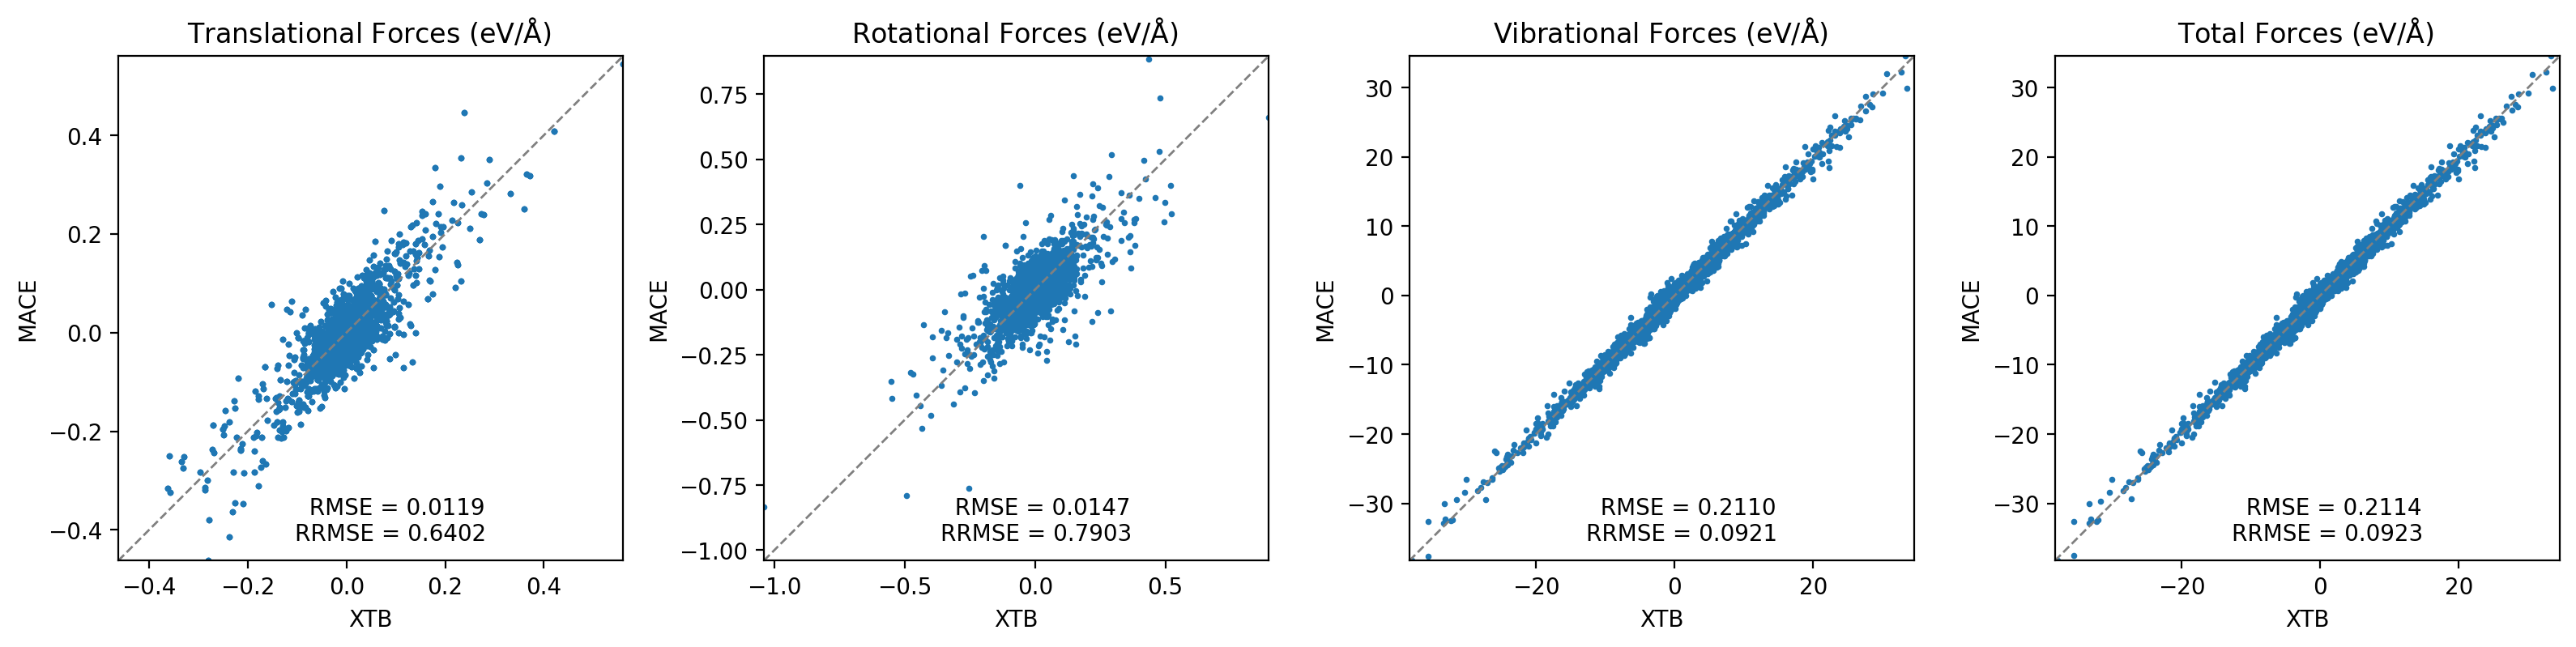

In [144]:
from aseMolec import pltProps as pp
from aseMolec import anaAtoms as aa

db1 = read('tests/mace01/solvent_test.xyz', ':')
ea.rename_prop_tag(db1, 'energy_xtb', 'energy') #Backward compatibility
ea.rename_prop_tag(db1, 'forces_xtb', 'forces') #Backward compatibility

db2 = read('tests/mace01/solvent_test.xyz', ':')
ea.rename_prop_tag(db2, 'MACE_energy', 'energy') #Backward compatibility
ea.rename_prop_tag(db2, 'MACE_forces', 'forces') #Backward compatibility

aa.extract_molecs(db1, intra_inter=True)
aa.extract_molecs(db2, intra_inter=True)

pp.plot_trans_rot_vib(db1, db2, labs=['XTB', 'MACE'])

Again, MACE performs better. However, iner-molecular are still difficult to capture - as we expect.

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
from aseMolec import extAtoms as ea

def plot_vscan(vsname='volumeScan', vspaths=['data', 'maceTests']):
    for i, vspath in enumerate(vspaths):
        db = read(vspath+'/'+vsname+'.xyz', ':')
        config = np.arange(len(db))
        energy = ea.get_prop(db, 'info', 'energy', peratom=True)
        plt.plot(config, energy, '.-', label=vspath, alpha=0.5)
    plt.xlabel(r'Volume Scan Config')
    plt.ylabel(r'Energy ($\rm eV/atom$)')
    plt.legend()
    plt.title(vsname)
    plt.tight_layout()

plot_vscan()

The `volume scan` is still not perfect, but MACE is smoother! More data will be needed to get this right. 

# Molecular Dynamics with MACE

MD is the ultimate test, let's check MACE stability. We will start by implementing a simple function to run Langevin dynamics. We will initialize the temperature at 300 K and remove all translations and rotations.

In [ ]:
from ase.io import read, write
from ase import units
from ase.md.langevin import Langevin
from ase.md.velocitydistribution import Stationary, ZeroRotation, MaxwellBoltzmannDistribution

import random
import os
import time
import numpy as np
import pylab as pl
from IPython import display

def simpleMD(init_conf, temp, calc, fname, s, T):
    init_conf.set_calculator(calc)

    #initialize the temperature
    random.seed(701) #just making sure the MD failure is reproducible
    MaxwellBoltzmannDistribution(init_conf, temperature_K=300) #initialize temperature at 300
    Stationary(init_conf)
    ZeroRotation(init_conf)

    dyn = Langevin(init_conf, 1.0*units.fs, temperature_K=temp, friction=0.1) #drive system to desired temperature

    %matplotlib inline

    time_fs = []
    temperature = []
    energies = []

    #remove previously stored trajectory with the same name
    os.system('rm -rfv '+fname)

    fig, ax = pl.subplots(2, 1, figsize=(6,6), sharex='all', gridspec_kw={'hspace': 0, 'wspace': 0})

    def write_frame():
            dyn.atoms.write(fname, append=True)
            time_fs.append(dyn.get_time()/units.fs)
            temperature.append(dyn.atoms.get_temperature())
            energies.append(dyn.atoms.get_potential_energy()/len(dyn.atoms))

            ax[0].plot(np.array(time_fs), np.array(energies), color="b")
            ax[0].set_ylabel('E (eV/atom)')

            # plot the temperature of the system as subplots
            ax[1].plot(np.array(time_fs), temperature, color="r")
            ax[1].set_ylabel('T (K)')
            ax[1].set_xlabel('Time (fs)')

            display.clear_output(wait=True)
            display.display(pl.gcf())
            time.sleep(0.01)

    dyn.attach(write_frame, interval=s)
    t0 = time.time()
    dyn.run(T)
    t1 = time.time()
    print("MD finished in {0:.2f} minutes!".format((t1-t0)/60))

## Compare MACE and XTB Dynamics

Now we can run MD with MACE. Let's try 2 picoseoncds starting from a single molecule config:

In [ ]:
 #let us start with a single molecule
init_conf = ea.sel_by_info_val(read('data/solvent_molecs.xyz',':'), 'Nmols', 1)[0].copy()

#we can use MACE as a calculator in ASE!
from mace.calculators import MACECalculator
mace_calc = MACECalculator(model_paths=['model_swa.model'], device='cuda', default_dtype="float32")


simpleMD(init_conf, temp=1200, calc=mace_calc, fname='mace_md.xyz', s=10, T=2000)


For reference, we can also run XTB dynamics from the same starting configuration.

In [ ]:
# reinitialize the original config
init_conf = ea.sel_by_info_val(read('data/solvent_molecs.xyz',':'), 'Nmols', 1)[0].copy()

from xtb.ase.calculator import XTB
xtb_calc = XTB(method="GFN2-xTB")

simpleMD(init_conf, temp=1200, calc=xtb_calc, fname='xtb_md.xyz', s=10, T=2000)

Great the dynamics are pretty stable! Download the trajectory files `.xyz` and visualize them with your favourite software.

Are the different dynamics sampling the correct distributions? Let us check the radial distribution functions (RDF). The [aseMolec](https://github.com/imagdau/aseMolec) package provides functionality to do that:

In [ ]:
from aseMolec import anaAtoms as aa

tag = 'HO_intra' #choose one of 'HH_intra', 'HC_intra', 'HO_intra', 'CC_intra', 'CO_intra', 'OO_intra'

for f in ['xtb_md', 'mace_md']:
    traj = read(f+'.xyz', ':')
    for at in traj:
        at.pbc = True
        at.cell = [100,100,100]
    rdf = aa.compute_rdfs_traj_avg(traj, rmax=5, nbins=50) #aseMolec provides functionality to compute RDFs
    plt.plot(rdf[1], rdf[0][tag], label=f, alpha=0.7, linewidth=3)

plt.legend();
plt.yticks([]);
plt.xlabel(r'R ($\rm \AA$)');
plt.ylabel('RDF '+tag);

Try it yourself! Look at other RDF types, how well are they reproduced? The MACE model performes better than GAP.

The trajectories here are pretty stable, but this is a pretty simple problem. We chose a single molecule at relatively small temperatures (for a molecule) and only ran for 2 picoseconds. In practice, given enough time and high enough temperature the initial models will fail.

Experiment with the starting configs, temperatures, simulation length, see if you can find problems with the potentials!

## The Molecular Liquid Condensed Phase

The MLIP was trained on clusters, can we simulate the liquid molecular environment?

In [ ]:
init_conf = read('data/ECEMC.xyz','4') #read a liquid config with periodic boundary conditions
init_conf.center()

simpleMD(init_conf, temp=500, calc=mace_calc, fname='liquid_md.xyz', s=10, T=2000)

This XTB calculator is non-periodic, so this dynamics would not be possible without an MLIP! Check for yourself, by replacing the calculator with xtb. The system is much larger than the example before (12 molecules vs just one), check how GAP scales with size by replacing the calculator with gap.


Transferability from clusters to the condensed phase environment is still an open research question. If this works, it implies that we might be able to learn on highly accuracte Quantum Chemistry methods on molecular clusters and make predictions (density, diffusivity) for the condensed phase! This is new Science!